# WebRender dashboard ETL script

You probably want to look at the [published dashboard](file:///Users/tsmith/projects/webrender-dashboard/dashboard.html).

You can check [scheduled run status](https://dbc-caf9527b-e073.cloud.databricks.com/#job/715).


### What's different?

* Metrics are summarized by build (vs date).
* Performance metrics are aggregated over users; this is important because it reduces the impacts of outlier users on our understanding of product performance, and because it reflects how WebRender changes the user experience at the user level.
* Pings are artisanally hand-selected so that comparisons between experiment branches are fair even in the presence of the various enrollment weirdnesses.

In [2]:
%r
library(boot)
library(dplyr, warn.conflicts=FALSE)
library(ggplot2)
library(sparklyr, warn.conflicts=FALSE)
library(tidyr, warn.conflicts=FALSE)

sc = spark_connect(method="databricks")

# Save result tables so we can access them from hala
final_outdb_path = "/dbfs/tdsmith/webrender.sqlite3"

In [3]:
from moztelemetry.dataset import Dataset
import pandas as pd
from pyspark.sql import Row
from pyspark.sql import functions as f
from pyspark.sql.types import StructType, StructField, StringType, BooleanType, IntegerType, DoubleType, LongType, MapType
from statsmodels.stats.weightstats import DescrStatsW

EXPERIMENT_ID = "prefflip-webrender-v1-2-1492568"
EXPERIMENT_ID_2 = "prefflip-webrender-v1-3-1492568"
PARTITIONS = [s.replace("-", "_") for s in (EXPERIMENT_ID, EXPERIMENT_ID_2)]

In [4]:
to_summarize = {
  "composite_time": "payload.processes.gpu.histograms.COMPOSITE_TIME",
  "content_frame_time": "payload.processes.gpu.histograms.CONTENT_FRAME_TIME",
  "content_frame_time_vsync": "payload.processes.gpu.histograms.CONTENT_FRAME_TIME_VSYNC",
  "content_paint_time": "payload.processes.content.histograms.CONTENT_PAINT_TIME",
  "tab_switch_composite": "payload.histograms.FX_TAB_SWITCH_COMPOSITE_E10S_MS",
  "content_full_paint_time": "payload.processes.gpu.histograms.CONTENT_FULL_PAINT_TIME",
  "page_load_ms": "payload.histograms.FX_PAGE_LOAD_MS_2"
}

to_pull = {}
for k, v in to_summarize.items():
  to_pull[k] = v + ".values"
  to_pull[k + "_sum"] = v + ".sum"

pings = (
  Dataset
  .from_source("telemetry-cohorts")
  .where(
    docType="main",
    experimentId=lambda x: x in PARTITIONS,
    submissionDate=lambda x: int(x) >= 20190102,
#    appBuildId='20190104093221',
  )
  .select(
    app_build_id="application.buildId",
    branch='environment.experiments."%s".branch' % EXPERIMENT_ID,
    branch2='environment.experiments."%s".branch' % EXPERIMENT_ID_2,
    client_id="clientId",
    gfx_info='environment.system.gfx',
    gfx_compositor="environment.system.gfx.features.compositor",
    corecount="environment.system.cpu.cores",
    cpucount="environment.system.cpu.count",
    normalized_channel="meta.normalizedChannel",
    profile_subsession_counter="payload.info.profileSubsessionCounter",
    session_id="payload.info.sessionId",
    target_pref_value='environment.settings.userPrefs."gfx.webrender.all.qualified"',
    # ---
    device_reset_reason_content="payload.processes.content.histograms.DEVICE_RESET_REASON.values",
    device_reset_reason_gpu="payload.processes.gpu.histograms.DEVICE_RESET_REASON.values",
    device_reset_reason_parent="payload.histograms.DEVICE_RESET_REASON.values",
    subsession_length="payload.info.subsessionLength",
    active_ticks='payload.processes.parent.scalars."browser.engagement.active_ticks"',
    total_uris='payload.processes.parent.scalars."browser.engagement.total_uri_count"',
    **to_pull
  )
  .records(sc)
)

def ping_to_row(x):
  for k, v in to_summarize.items():
    x[k + "_count"] = sum((x[k] or {}).values())
  
  x["experiment"] = (x["branch"] and 2) or 3
  x["branch"] = x["branch"] or x["branch2"]
  del x["branch2"]
  
  # Aggregate DEVICE_RESET_REASON for crash rates
  procs = ("parent", "content", "gpu")
  x["device_reset_reason_total"] = 0
  for proc in procs:
    key = "device_reset_reason_" + proc
    x[key + "_count"] = sum((x[key] or {}).values())
    x["device_reset_reason_total"] += x[key + "_count"]
    del x[key]
  
  # Calculate usage hours for crash rates
  # Based on https://github.com/mozilla/telemetry-streaming/blob/ee2eafd18a8b12a3fafca496d58789f641069bf6/src/main/scala/com/mozilla/telemetry/pings/MainPing.scala#L71-L82
  subsession_length = x["subsession_length"] or 0
  x["usage_hours"] = max(min(subsession_length/3600., 25.), 0.)
  return Row(**x)

fetching 29275.50530MB in 9079 files...

In [5]:
#pings = pings.filter(lambda p: len(p["gfx_info"]["monitors"]) == 1 and p["gfx_info"]["monitors"][0]["refreshRate"] == 60)

In [6]:
sdf_fields = [
  StructField("app_build_id", StringType(), True),
  StructField("branch", StringType(), False),
  StructField("client_id", StringType(), False),
  StructField("experiment", IntegerType(), False),
  StructField("gfx_compositor", StringType(), True),
  StructField("cpucount", LongType(), True),
  StructField("corecount", LongType(), True),
  StructField("normalized_channel", StringType(), True),
  StructField("profile_subsession_counter", LongType(), True),  
  StructField("session_id", StringType(), True),
  StructField("target_pref_value", BooleanType(), True),
  StructField("device_reset_reason_parent_count", LongType(), True),
  StructField("device_reset_reason_content_count", LongType(), True),
  StructField("device_reset_reason_gpu_count", LongType(), True),
  StructField("device_reset_reason_total", LongType(), True),
  StructField("active_ticks", LongType(), True),
  StructField("total_uris", LongType(), True),
  StructField("subsession_length", LongType(), True),
  StructField("usage_hours", DoubleType(), True),
]

for k, v in to_summarize.items():
  sdf_fields.extend([
    StructField(k, MapType(StringType(), LongType()), True),
    StructField(k + "_sum", LongType(), True),
    StructField(k + "_count", LongType(), True),
  ])

sdf = spark.createDataFrame(pings.map(ping_to_row), schema=StructType(sdf_fields))

In [7]:
sdf.cache()
None

In [8]:
# Because compositor changes don't take effect until the browser restarts,
# we should discard the enrollment session we observe for each client.
# We'll find those sessions here, and then anti-join against this table later.

first_sessions = (
  sdf
  .orderBy(sdf.experiment, sdf.client_id, sdf.branch, sdf.profile_subsession_counter)
  .groupBy(sdf.experiment, sdf.client_id, sdf.branch)
  .agg(
    f.first(sdf.session_id).alias("session_id"),
  )
)

In [9]:
# Broadcast joins time-out unless the cluster is warm
spark.sql("SET spark.sql.autoBroadcastJoinThreshold = -1")

subsessions = (
  sdf
  .join(first_sessions, on=["experiment", "client_id", "branch", "session_id"], how="left_anti")
  .where(sdf.target_pref_value.isNotNull())
  .where(
    ((sdf.branch == "disabled") & (sdf.gfx_compositor == "d3d11"))
    | ((sdf.branch == "enabled") & (sdf.gfx_compositor == "webrender"))
  )
  .where(
    #(sdf.normalized_channel == "beta") | 
    (sdf.normalized_channel == "nightly")
  )
  .filter("app_build_id >= '20190104093221'")
  #.filter("app_build_id >= '20190107214730'")

  .cache()
)

In [10]:
sorted(subsessions.filter("normalized_channel != 'beta'").select('app_build_id').rdd.map(lambda x: x['app_build_id']).countByValue().items())

Out[ 8 ]: 
[(u'20190104093221', 1135),
 (u'20190104132412', 1999),
 (u'20190104214806', 3441),
 (u'20190105123739', 2417),
 (u'20190105215256', 2273),
 (u'20190106095006', 3487),
 (u'20190106214444', 2371),
 (u'20190107093040', 3705),
 (u'20190107214730', 1848),
 (u'20190108101613', 4999),
 (u'20190108215840', 5704),
 (u'20190109092644', 4752),
 (u'20190109163702', 2647),
 (u'20190109214248', 5031),
 (u'20190110093854', 8248),
 (u'20190110214210', 3695),
 (u'20190111093148', 6518),
 (u'20190111215452', 5057),
 (u'20190112094119', 6546),
 (u'20190112213654', 4668),
 (u'20190113100555', 4626),
 (u'20190113213646', 826),
 (u'20190114014511', 1514),
 (u'20190114104248', 234)]

In [11]:
subsessions.createOrReplaceGlobalTempView("webrender_metrics")

In [12]:
# Compute per-user quantiles for CONTENT_PAINT_TIME

def generate_quantile_udf(sdf, grouping_fields, bucket_field, count_field, quantiles):
  """
  sdf: Spark DataFrame
  grouping_fields: list of strings representing columns from sdf
  bucket_field: Name of the field containing histogram buckets
  count_field: Name of the field containing counts
  quantiles: List of quantiles as floating point values on [0, 1]
  """
  schema = (
    sdf
    .select(*grouping_fields)
    .schema
    .add(StructField("quantile", DoubleType(), False))
    .add(StructField("value", DoubleType(), True))
  )
  
  @f.pandas_udf(schema, f.PandasUDFType.GROUPED_MAP)
  def udf(df):
    stats = DescrStatsW(df[bucket_field].astype(float), df[count_field]).quantile(quantiles)
    stats = stats.rename_axis("quantile").reset_index(name="value").assign(_dummy=1)
    grouping_variables = df[grouping_fields].iloc[:1].assign(_dummy=1)
    result = grouping_variables.merge(stats, on="_dummy").drop("_dummy", axis=1)
    return result
  
  return udf

metric_quantiles = generate_quantile_udf(
  subsessions,
  ["client_id", "branch", "app_build_id", "normalized_channel"],
  bucket_field="bucket",
  count_field="count",
  quantiles=[0.5, 0.9, 0.95, 0.99]
)

paint_time_quantiles = (
  subsessions
  .select(
    subsessions.client_id,
    subsessions.branch,
    subsessions.normalized_channel,
    subsessions.app_build_id,
    f.explode(subsessions.content_paint_time).alias("bucket", "count")
  )
  .groupBy(subsessions.client_id, subsessions.branch, subsessions.app_build_id, subsessions.normalized_channel, "bucket")
  .agg(f.sum("count").alias("count"))
  .groupBy(subsessions.client_id, subsessions.branch, subsessions.app_build_id, subsessions.normalized_channel)
  .apply(metric_quantiles)
)

paint_time_quantiles.createOrReplaceGlobalTempView("wr_paint_time_quantiles")

In [13]:
# Changes to CONTENT_FRAME_TIME are only user-visible when CONTENT_FRAME_TIME exceeds 200.
# Count the fraction of CONTENT_FRAME_TIME events where the threshold is exceeded.
# (The threshold is set to 192 because of the binning of the histogram.)

def generate_threshold_udf(sdf, grouping_fields, bucket_field, count_field, thresholds):
  """
  sdf: Spark DataFrame
  grouping_fields: list of strings representing columns from sdf
  bucket_field: Name of the field containing histogram buckets
  count_field: Name of the field containing counts
  thresholds: List of thresholds. Should probably align on the left edge of a bucket.
  """
  schema = (
    sdf
    .select(*grouping_fields)
    .schema
    .add(StructField("threshold", IntegerType(), False))
    .add(StructField("fraction_exceeding", DoubleType(), True))
  )
  
  @f.pandas_udf(schema, f.PandasUDFType.GROUPED_MAP)
  def udf(df):
    rows = []
    all_sum = float(df[count_field].sum())
    for tx in thresholds:
      fraction = df.loc[df[bucket_field].astype(int) >= tx, count_field].sum() / all_sum
      rows.append({"threshold": tx, "fraction_exceeding": fraction})
    data = pd.DataFrame(rows).assign(_dummy=1)
    grouping_variables = df[grouping_fields].iloc[:1].assign(_dummy=1)
    result = grouping_variables.merge(data, on="_dummy").drop("_dummy", axis=1)
    return result
  
  return udf

vsync_threshold = generate_threshold_udf(
  subsessions,
  ["client_id", "branch", "app_build_id", "normalized_channel"],
  bucket_field="bucket",
  count_field="count",
  thresholds=[192],
)

slow_content_frame_time = (
  subsessions
  .select(
    subsessions.client_id,
    subsessions.branch,
    subsessions.normalized_channel,
    subsessions.app_build_id,
    f.explode(subsessions.content_frame_time).alias("bucket", "count")
  )
  .groupBy(subsessions.client_id, subsessions.branch, subsessions.app_build_id, subsessions.normalized_channel)
  .apply(vsync_threshold)
)

slow_content_frame_time.createOrReplaceGlobalTempView("wr_slow_content_frame_time")

In [14]:
# Changes to CONTENT_FRAME_TIME_VSYNC are only user-visible when CONTENT_FRAME_TIME_VSYNC exceeds 200.
# Count the fraction of CONTENT_FRAME_TIME_VSYNC events where the threshold is exceeded.

vsync_threshold = generate_threshold_udf(
  subsessions,
  ["client_id", "branch", "app_build_id", "normalized_channel", "corecount"],
  bucket_field="bucket",
  count_field="count",
  thresholds=[200],
)

slow_content_frame_time_vsync = (
  subsessions
  .select(
    subsessions.client_id,
    subsessions.corecount,
    subsessions.branch,
    subsessions.normalized_channel,
    subsessions.app_build_id,
    f.explode(subsessions.content_frame_time_vsync).alias("bucket", "count")
  )
  .groupBy(subsessions.client_id, subsessions.branch, subsessions.app_build_id, subsessions.normalized_channel, subsessions.corecount)
  .apply(vsync_threshold)
)

slow_content_frame_time_vsync.createOrReplaceGlobalTempView("wr_slow_content_frame_time_vsync")
slow_content_frame_time_vsync.count()

Out[ 12 ]: 25952

In [15]:
sorted(slow_content_frame_time_vsync.select('app_build_id').rdd.countByValue().items())

Out[ 13 ]: 
[(Row(app_build_id=u'20190104093221'), 77),
 (Row(app_build_id=u'20190104132412'), 648),
 (Row(app_build_id=u'20190104214806'), 948),
 (Row(app_build_id=u'20190105123739'), 749),
 (Row(app_build_id=u'20190105215256'), 744),
 (Row(app_build_id=u'20190106095006'), 1037),
 (Row(app_build_id=u'20190106214444'), 747),
 (Row(app_build_id=u'20190107093040'), 1131),
 (Row(app_build_id=u'20190107214730'), 646),
 (Row(app_build_id=u'20190108101613'), 1397),
 (Row(app_build_id=u'20190108215840'), 1630),
 (Row(app_build_id=u'20190109092644'), 1518),
 (Row(app_build_id=u'20190109163702'), 913),
 (Row(app_build_id=u'20190109214248'), 1566),
 (Row(app_build_id=u'20190110093854'), 2098),
 (Row(app_build_id=u'20190110214210'), 1234),
 (Row(app_build_id=u'20190111093148'), 1789),
 (Row(app_build_id=u'20190111215452'), 1598),
 (Row(app_build_id=u'20190112094119'), 1703),
 (Row(app_build_id=u'20190112213654'), 1437),
 (Row(app_build_id=u'20190113100555'), 1336),
 (Row(app_build_id=u'20190113213646'), 354),
 (Row(app_build_id=u'20190114014511'), 525),
 (Row(app_build_id=u'20190114104248'), 127)]

In [16]:
# Summarize instances of other performance metrics exceeding 16ms

# to_summarize = {
#   "composite_time": "payload.processes.gpu.histograms.COMPOSITE_TIME",
#   "content_paint_time": "payload.processes.content.histograms.CONTENT_PAINT_TIME",
#   "content_full_paint_time": "payload.processes.gpu.histograms.CONTENT_FULL_PAINT_TIME",
# }

time_threshold = generate_threshold_udf(
  subsessions,
  ["client_id", "branch", "app_build_id", "normalized_channel"],
  bucket_field="bucket",
  count_field="count",
  thresholds=[16],
)

time_threshold_histograms = ["composite_time", "content_paint_time", "content_full_paint_time"]
for h in time_threshold_histograms:
  slow_df = (
    subsessions
    .select(
      subsessions.client_id,
      subsessions.branch,
      subsessions.normalized_channel,
      subsessions.app_build_id,
      f.explode(h).alias("bucket", "count")
    )
    .groupBy(subsessions.client_id, subsessions.branch, subsessions.app_build_id, subsessions.normalized_channel)
    .apply(time_threshold)
  )
  slow_df.createOrReplaceGlobalTempView("wr_slow_%s" % h)

## Performance metrics

Error bars are 95% confidence intervals for the central parameter of the per-user aggregate assuming a log-normal population distribution.

In [18]:
%r
metrics = tbl(sc, "global_temp.webrender_metrics")
per_user_build = metrics %>%
  select(app_build_id, normalized_channel, branch, client_id, ends_with("_count"), ends_with("_sum")) %>%
  select(-starts_with("device_reset_reason")) %>%
  group_by(app_build_id, normalized_channel, branch, client_id) %>%
  summarize_all(sum) %>%
  collect %>%
  gather("metric", "value", ends_with("_count"), ends_with("_sum")) %>%
  separate(metric, c("metric", "agg"), sep="_(?!.*_)") %>%
  spread(agg, value) %>%
  mutate(mean=sum/count)

In [19]:
%r
perf_medians = per_user_build %>%
  group_by(app_build_id, normalized_channel, branch, metric) %>%
  summarize(
    user_median=median(mean, na.rm=TRUE),
    log_sd=sd(log10(mean+1), na.rm=TRUE),
    log_sem=log_sd/sqrt(n()),
    log_ymin=log10(user_median)-1.96*log_sem,
    log_ymax=log10(user_median)+1.96*log_sem
  )

In [20]:
%r
slow_content_frame_time = tbl(sc, "global_temp.wr_slow_content_frame_time") %>% collect

In [21]:
%r
slow_content_frame_boot = function(df) {
  ci = boot(df$fraction_exceeding, function(data, x) median(data[x], na.rm=TRUE), 1000) %>%
     boot.ci(0.95, "basic")
  data.frame(
    ymin=ci$basic[4],
    y=ci$t0,
    ymax=ci$basic[5]
  ) * 100
}

slow_content_frame_time_summary = slow_content_frame_time %>%
  group_by(normalized_channel, app_build_id, branch) %>%
  do(slow_content_frame_boot(.))

In [22]:
%r
slow_content_frame_time_vsync = tbl(sc, "global_temp.wr_slow_content_frame_time_vsync") %>% collect
slow_content_frame_time_vsync_summary = slow_content_frame_time_vsync %>%
  group_by(normalized_channel, branch, app_build_id, corecount) %>%
  do(slow_content_frame_boot(.))

[1] "All values of t are equal to 0.0913139921267436 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.428447759206233 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0574929768478156 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.265048125269358 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.00558993425877086 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.4 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.297297297297297 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.00928104575163399 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0479359797163458 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0498461470621875 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.155555555555556 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.051975051975052 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.795031055900621 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0540453400503778 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0346417483785695 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0455991516436903 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.147088389459324 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.494120926460899 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0347468653891649 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0965650550479644 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.134615384615385 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0347367065791168 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.118553935860058 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.218267411676713 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0441562451752354 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.139387426114992 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0289949150708644 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.057115467613957 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.127052812679214 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.142460579307834 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.263585894127766 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0338740982165745 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.228717655934588 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.103539906994401 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0426185516048162 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0113605626183392 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.078125 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0590175953079179 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0273524254821742 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0512585264669512 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0420066179999495 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.0361898793670688 \n Cannot calculate confidence intervals"
[1] "All values of t are equal to 0.049346879535558

In [23]:
%r
nrow(slow_content_frame_time_vsync)

[1] 25952

In [24]:
%r
slow_content_frame_time_vsync_total_summary = slow_content_frame_time_vsync %>%
  group_by(normalized_channel, branch,corecount) %>%
  do(slow_content_frame_boot(.))
slow_content_frame_time_vsync_total_summary


[1] "All values of t are equal to 0.0113605626183392 \n Cannot calculate confidence intervals"
# A tibble: 21 x 6
# Groups: normalized_channel, branch, corecount [21]
 normalized_channel branch corecount ymin y ymax
 
 1 nightly disabled 1 7.01 12.8 16.0 
 2 nightly disabled 2 9.04 10.1 11.3 
 3 nightly disabled 3 5.80 7.43 8.53
 4 nightly disabled 4 5.56 5.74 5.92
 5 nightly disabled 5 4.14 14.1 16.6 
 6 nightly disabled 6 4.00 4.27 4.59
 7 nightly disabled 8 3.62 4.15 4.63
 8 nightly disabled 10 1.59 3.29 5.26
 9 nightly disabled 16 4.24 5.18 5.83
10 nightly disabled 20 3.68 4.34 5.21
# ... with 11 more rows

In [25]:
%r
slow_content_frame_boot_mean = function(df) {
  ci = boot(df$fraction_exceeding, function(data, x) mean(data[x], na.rm=TRUE), 1000) %>%
     boot.ci(0.95, "basic")
  data.frame(
    ymin=ci$basic[4],
    y=ci$t0,
    ymax=ci$basic[5]
  ) * 100
}
slow_content_frame_time_vsync_total_summary = slow_content_frame_time_vsync %>%
  group_by(normalized_channel, branch, corecount) %>%
  do(slow_content_frame_boot_mean(.))
slow_content_frame_time_vsync_total_summary

[1] "All values of t are equal to 0.0113605626183392 \n Cannot calculate confidence intervals"
# A tibble: 21 x 6
# Groups: normalized_channel, branch, corecount [21]
 normalized_channel branch corecount ymin y ymax
 
 1 nightly disabled 1 10.2 17.1 22.1 
 2 nightly disabled 2 13.0 13.9 14.8 
 3 nightly disabled 3 9.10 11.0 12.6 
 4 nightly disabled 4 10.5 10.8 11.1 
 5 nightly disabled 5 11.4 16.6 20.8 
 6 nightly disabled 6 9.19 9.90 10.6 
 7 nightly disabled 8 9.89 11.0 12.1 
 8 nightly disabled 10 8.42 15.2 20.6 
 9 nightly disabled 16 4.04 10.8 15.8 
10 nightly disabled 20 2.30 5.27 6.99
# ... with 11 more rows

In [26]:
%r
slow_content_frame_time_total_summary = slow_content_frame_time %>%
  group_by(normalized_channel, branch) %>%
  do(slow_content_frame_boot(.))
slow_content_frame_time_total_summary

# A tibble: 2 x 5
# Groups: normalized_channel, branch [2]
 normalized_channel branch ymin y ymax
 
1 nightly disabled 1.46 1.51 1.56
2 nightly enabled 2.33 2.41 2.49

In [27]:
%r
slow_content_frame_time_vsync %>% filter(branch == 'enabled') %>% summary

client_id branch app_build_id normalized_channel
 Length:13579 Length:13579 Length:13579 Length:13579 
 Class :character Class :character Class :character Class :character 
 Mode :character Mode :character Mode :character Mode :character 
 
 
 
 corecount threshold fraction_exceeding
 Min. : 1.000 Min. :200 Min. :0.00000 
 1st Qu.: 4.000 1st Qu.:200 1st Qu.:0.03076 
 Median : 4.000 Median :200 Median :0.06600 
 Mean : 4.637 Mean :200 Mean :0.13483 
 3rd Qu.: 6.000 3rd Qu.:200 3rd Qu.:0.15677 
 Max. :18.000 Max. :200 Max. :1.00000

In [28]:
%r
slow_content_frame_time_vsync %>% filter(branch == 'disabled') %>% summary

client_id branch app_build_id normalized_channel
 Length:12373 Length:12373 Length:12373 Length:12373 
 Class :character Class :character Class :character Class :character 
 Mode :character Mode :character Mode :character Mode :character 
 
 
 
 corecount threshold fraction_exceeding
 Min. : 1.00 Min. :200 Min. :0.00000 
 1st Qu.: 4.00 1st Qu.:200 1st Qu.:0.02308 
 Median : 4.00 Median :200 Median :0.05590 
 Mean : 4.57 Mean :200 Mean :0.10880 
 3rd Qu.: 6.00 3rd Qu.:200 3rd Qu.:0.12177 
 Max. :24.00 Max. :200 Max. :0.99660

In [29]:
%r
slow_content_frame_time_vsync_summary

# A tibble: 48 x 6
# Groups: normalized_channel, branch, app_build_id [48]
 normalized_channel branch app_build_id ymin y ymax
 
 1 nightly disabled 20190104093221 3.82 5.13 6.67
 2 nightly disabled 20190104132412 5.64 6.50 7.17
 3 nightly disabled 20190104214806 4.35 5.10 5.80
 4 nightly disabled 20190105123739 4.95 6.21 6.82
 5 nightly disabled 20190105215256 4.35 5.29 6.01
 6 nightly disabled 20190106095006 4.51 5.22 5.78
 7 nightly disabled 20190106214444 4.10 5.14 5.86
 8 nightly disabled 20190107093040 4.68 5.54 6.19
 9 nightly disabled 20190107214730 4.64 5.52 6.53
10 nightly disabled 20190108101613 5.05 5.73 6.34
# ... with 38 more rows

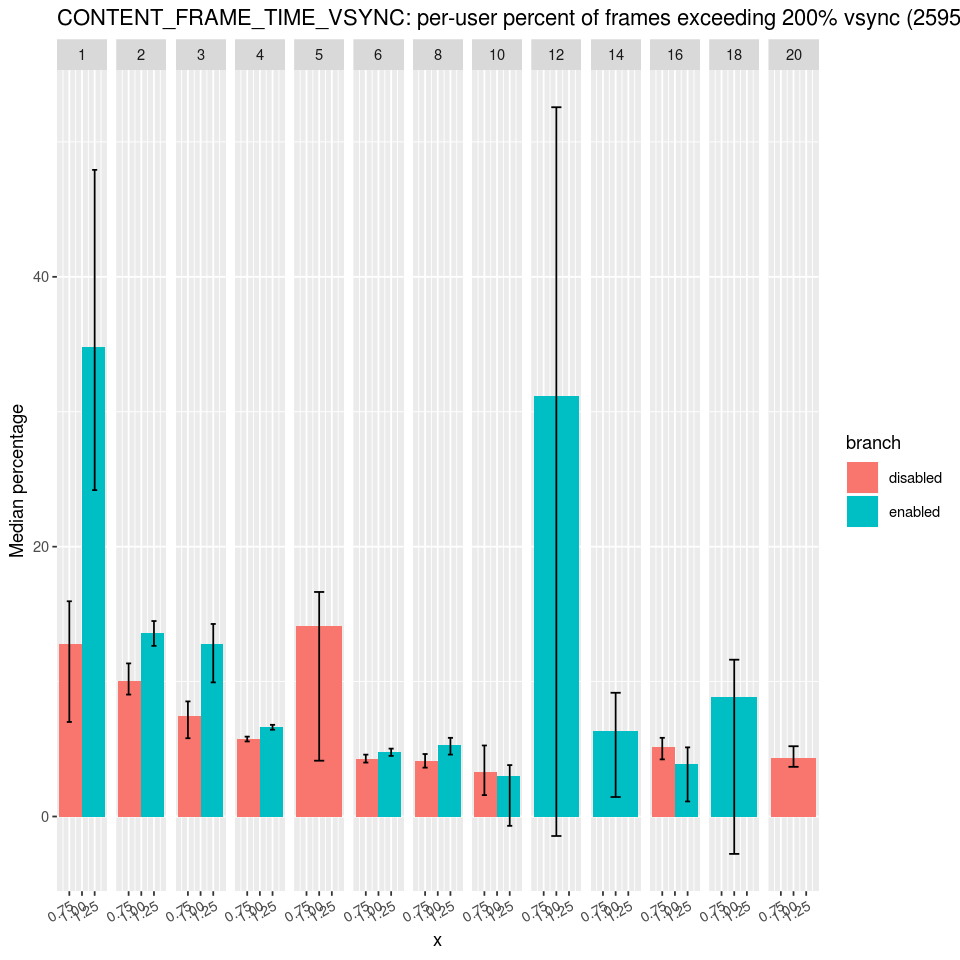

In [30]:
%r
options(repr.plot.width=2000)
slow_content_frame_time_vsync_total_summary %>%
  #inner_join(display_builds) %>%
  ggplot(aes(1, y, ymin=ymin, ymax=ymax, fill=branch)) +
    facet_grid(~corecount, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    labs(title=sprintf("CONTENT_FRAME_TIME_VSYNC: per-user percent of frames exceeding 200%% vsync (%d users)", nrow(slow_content_frame_time_vsync)), y="Median percentage")

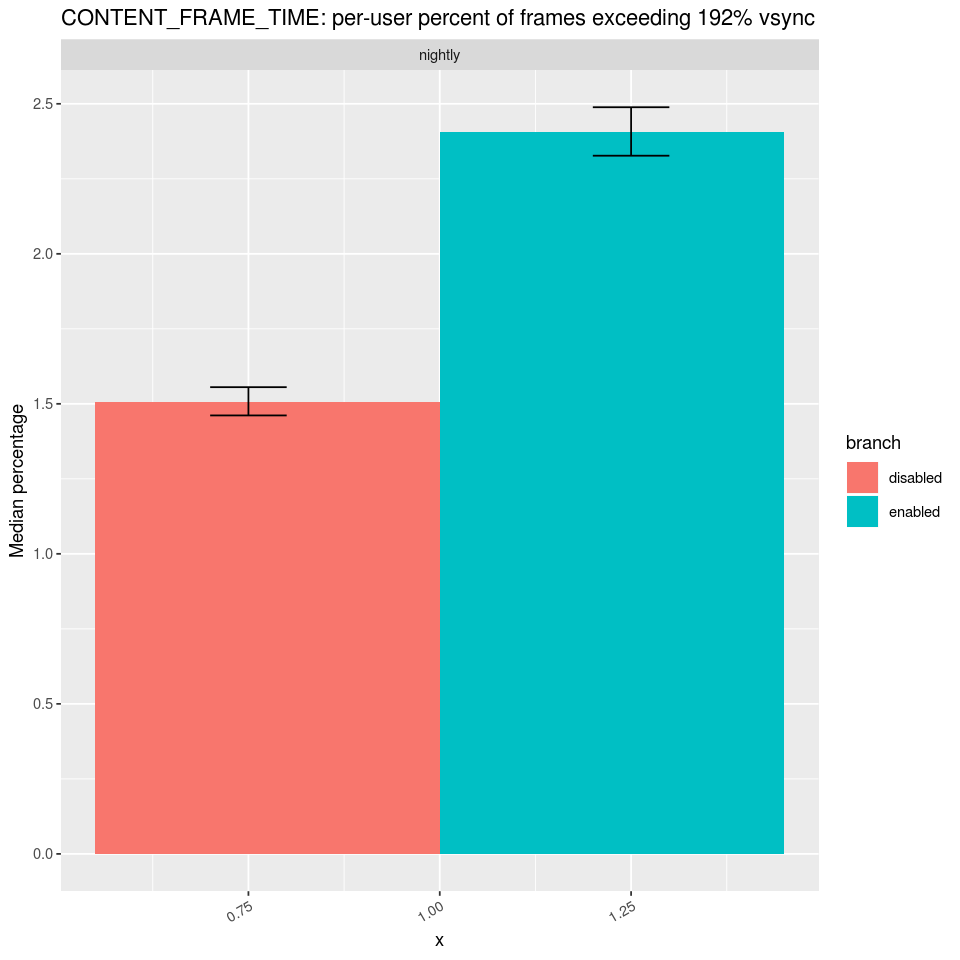

In [31]:
%r
slow_content_frame_time_total_summary %>%
  #inner_join(display_builds) %>%
  ggplot(aes(1, y, ymin=ymin, ymax=ymax, fill=branch)) +
    facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    labs(title="CONTENT_FRAME_TIME: per-user percent of frames exceeding 192% vsync", y="Median percentage")

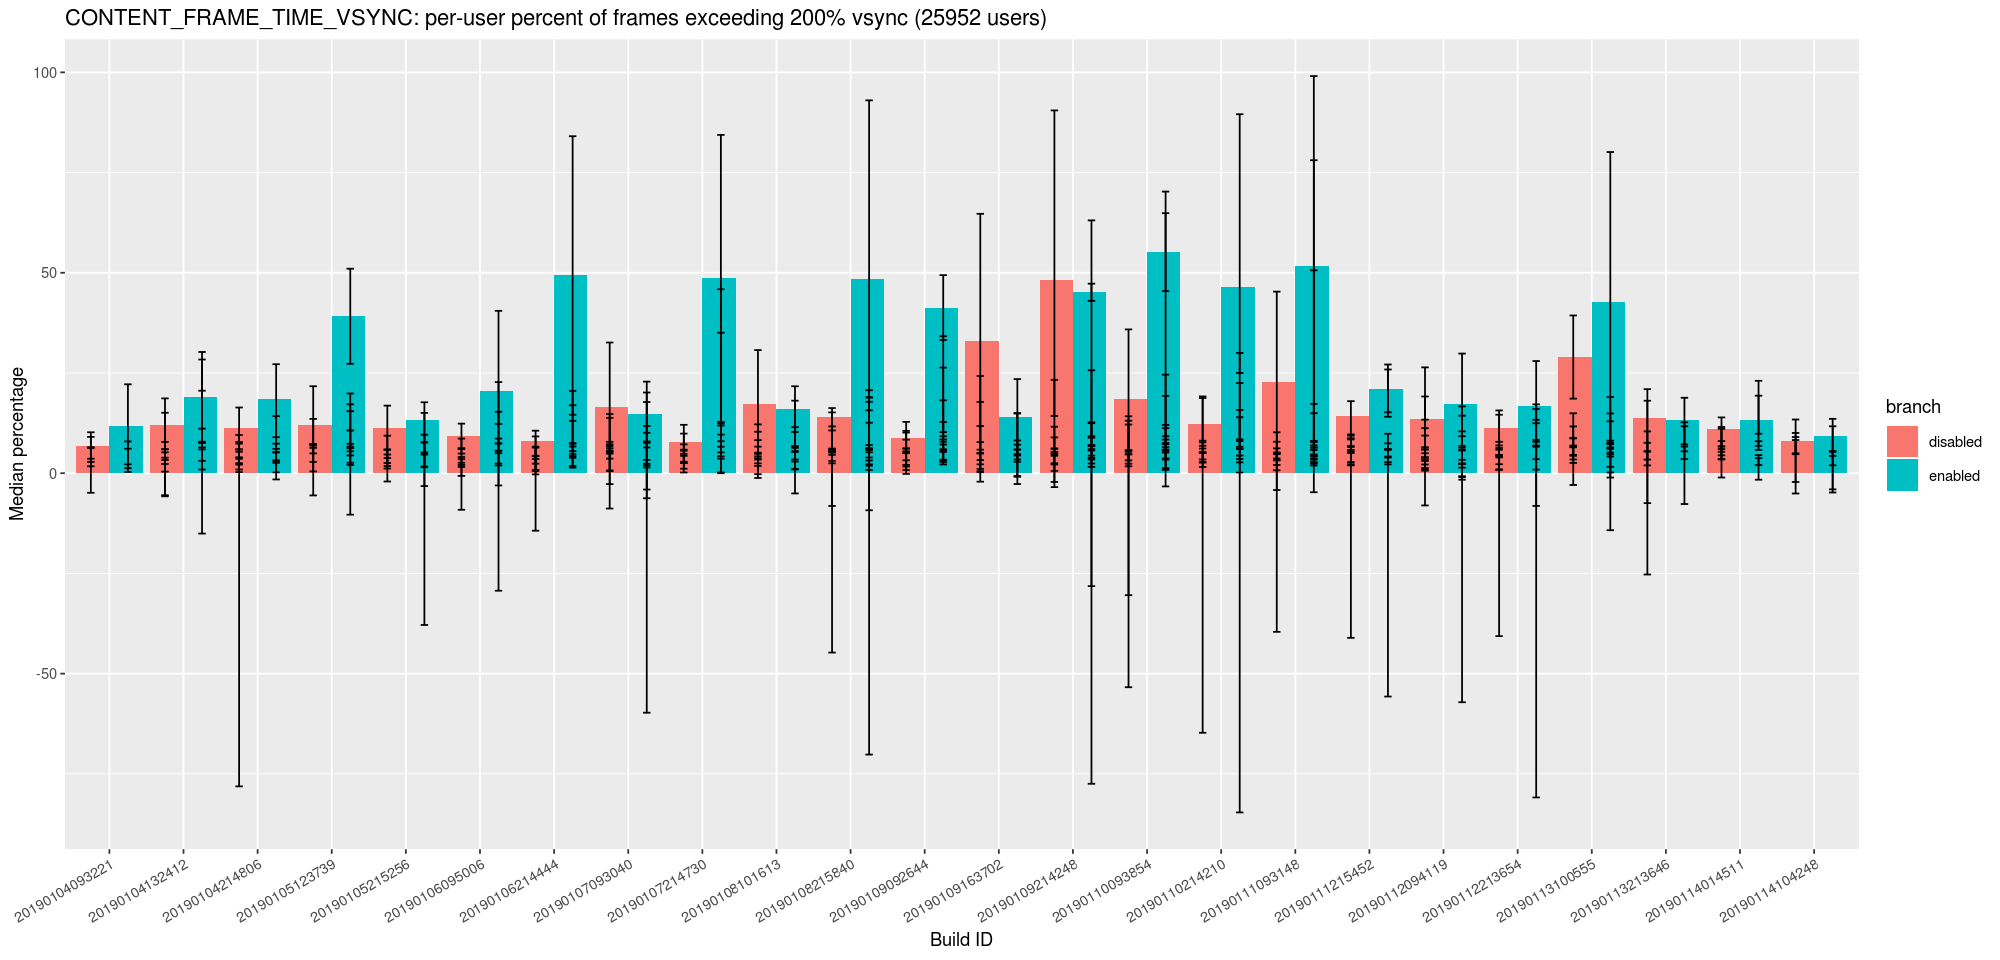

In [32]:
%r
slow_content_frame_time_vsync_summary %>%
  #inner_join(display_builds) %>%
  ggplot(aes(app_build_id, y, ymin=ymin, ymax=ymax, fill=branch)) +
    #facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    labs(title=sprintf("CONTENT_FRAME_TIME_VSYNC: per-user percent of frames exceeding 200%% vsync (%d users)", nrow(slow_content_frame_time_vsync)), x="Build ID", y="Median percentage")

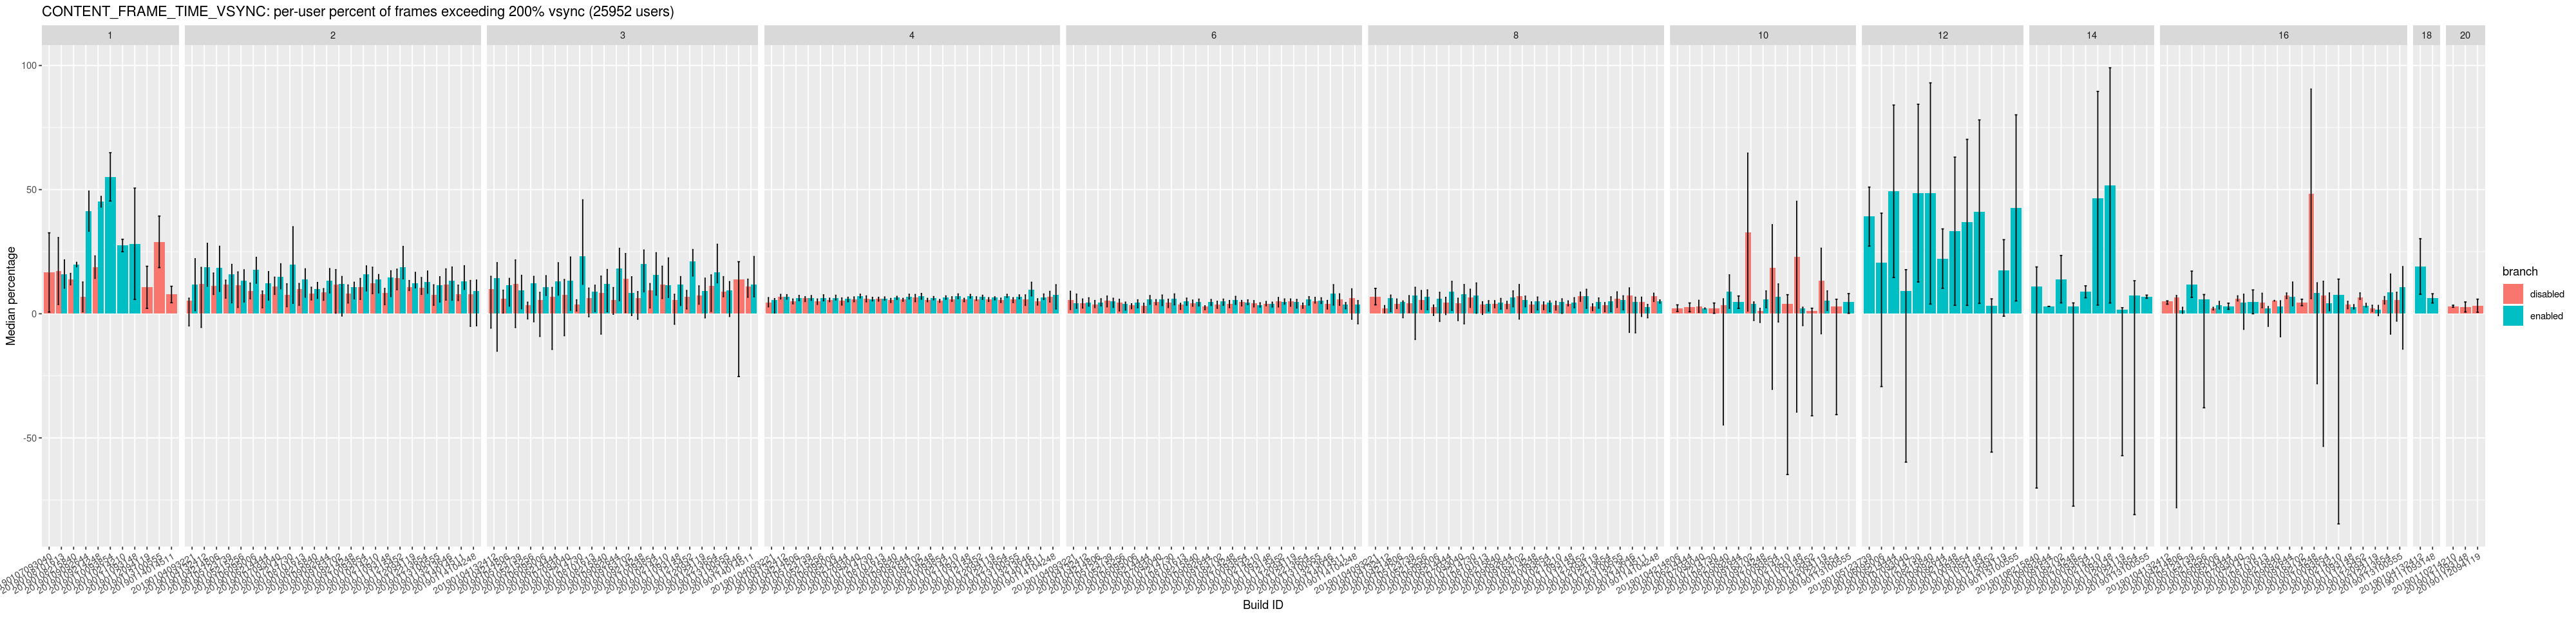

In [33]:
%r
options(repr.plot.width=2000)
slow_content_frame_time_vsync_summary %>%
  #inner_join(display_builds) %>%
  ggplot(aes(app_build_id, y, ymin=ymin, ymax=ymax, fill=branch)) +
    facet_grid(~corecount, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    labs(title=sprintf("CONTENT_FRAME_TIME_VSYNC: per-user percent of frames exceeding 200%% vsync (%d users)", nrow(slow_content_frame_time_vsync)), x="Build ID", y="Median percentage")

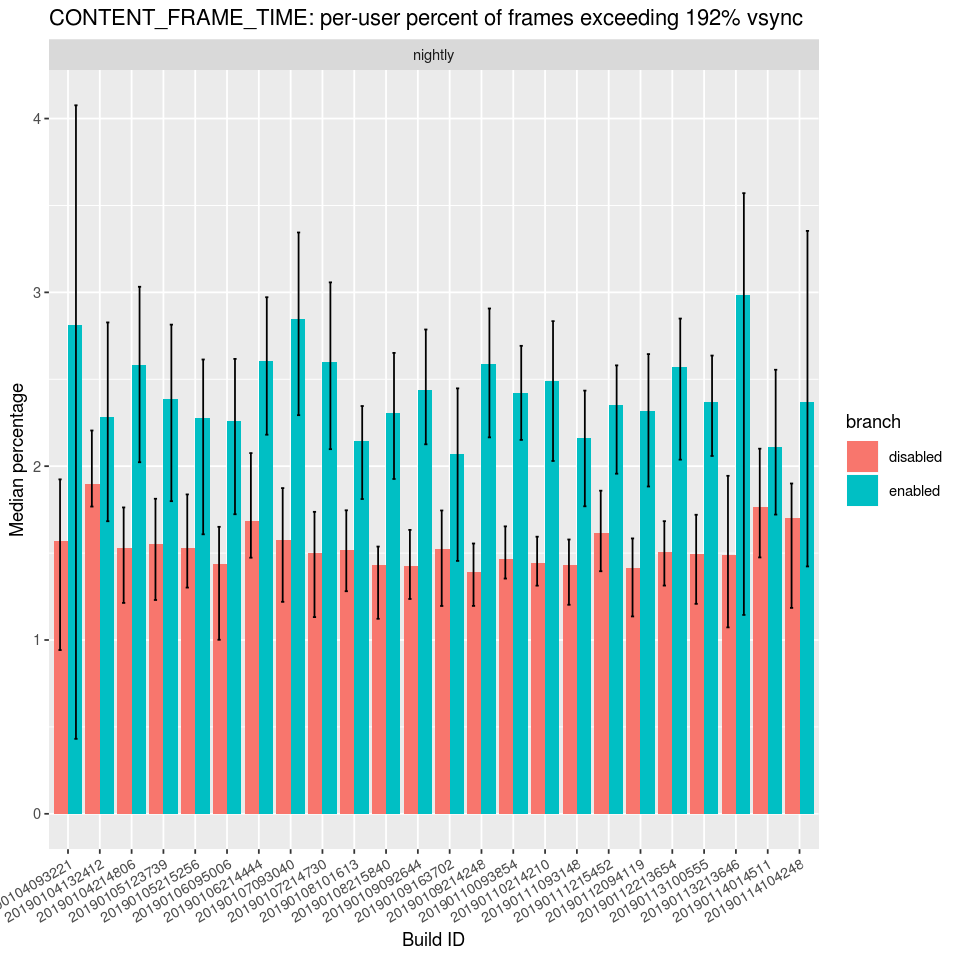

In [34]:
%r
slow_content_frame_time_summary %>%
  #inner_join(display_builds) %>%
  ggplot(aes(app_build_id, y, ymin=ymin, ymax=ymax, fill=branch)) +
    facet_grid(~normalized_channel, scales="free_x", space="free_x") +
    geom_col(position=position_dodge()) +
    geom_errorbar(width=0.2, position=position_dodge(width=1)) +
    theme(axis.text.x=element_text(angle=30, hjust=1)) +
    labs(title="CONTENT_FRAME_TIME: per-user percent of frames exceeding 192% vsync", x="Build ID", y="Median percentage")

In [35]:
%r
slow_content_frame_time %>% filter(app_build_id == '20190104093221')

# A tibble: 77 x 6
 client_id branch app_build_id normalized_chan… threshold fraction_exceed…
 
 1 c3b92be2-82… enabl… 20190104093… nightly 192 0.0734 
 2 4fcb4af6-bd… enabl… 20190104093… nightly 192 0.0158 
 3 ce0990f4-f5… disab… 20190104093… nightly 192 0.00175
 4 a7254d6a-5a… enabl… 20190104093… nightly 192 0.00425
 5 c494aa61-ca… disab… 20190104093… nightly 192 0.0130 
 6 68d229b1-19… disab… 20190104093… nightly 192 0.0600 
 7 b5d8bb01-28… disab… 20190104093… nightly 192 0.0166 
 8 5c702947-3a… enabl… 20190104093… nightly 192 0.112 
 9 d58810b6-76… enabl… 20190104093… nightly 192 0.00495
10 d312e828-0f… disab… 20190104093… nightly 192 0.0231 
# ... with 67 more rows

In [36]:
%r
joined <- slow_content_frame_time %>% filter(app_build_id == '20190104093221') %>% inner_join(slow_content_frame_time_vsync, by=c('app_build_id', 'branch', 'client_id', 'normalized_channel'), suffix=c('192', 'vsync')) %>% select(branch, fraction_exceeding192, fraction_exceedingvsync)
joined %>% arrange(branch,fraction_exceeding192)

# A tibble: 77 x 3
 branch fraction_exceeding192 fraction_exceedingvsync
 
 1 disabled 0.00175 0.00956
 2 disabled 0.00265 0.0103 
 3 disabled 0.00319 0.00910
 4 disabled 0.00319 0.0274 
 5 disabled 0.00325 0.0221 
 6 disabled 0.00347 0.0216 
 7 disabled 0.00401 0.0165 
 8 disabled 0.00518 0.0212 
 9 disabled 0.00548 0.0422 
10 disabled 0.00782 0.0645 
# ... with 67 more rows

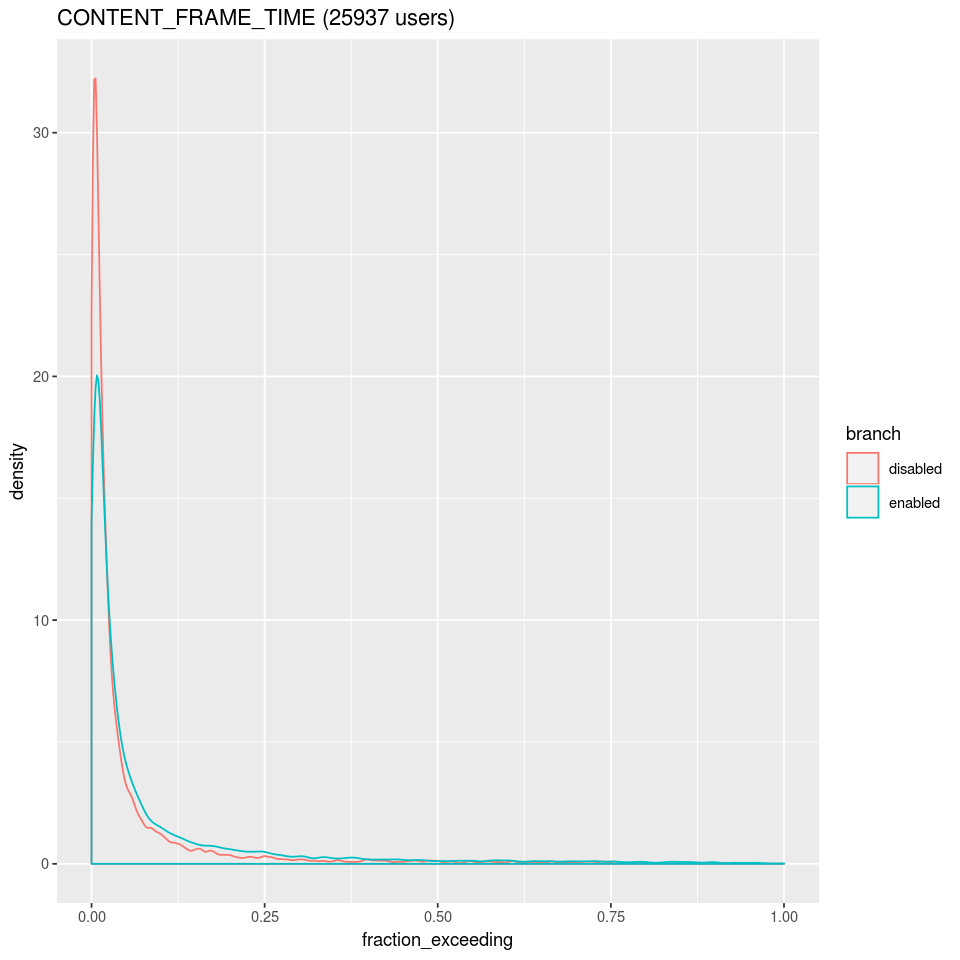

In [37]:
%r
slow_content_frame_time %>% ggplot(aes(x=fraction_exceeding, color=branch)) + geom_density() + labs(title=sprintf("CONTENT_FRAME_TIME (%d users)", nrow(slow_content_frame_time)))

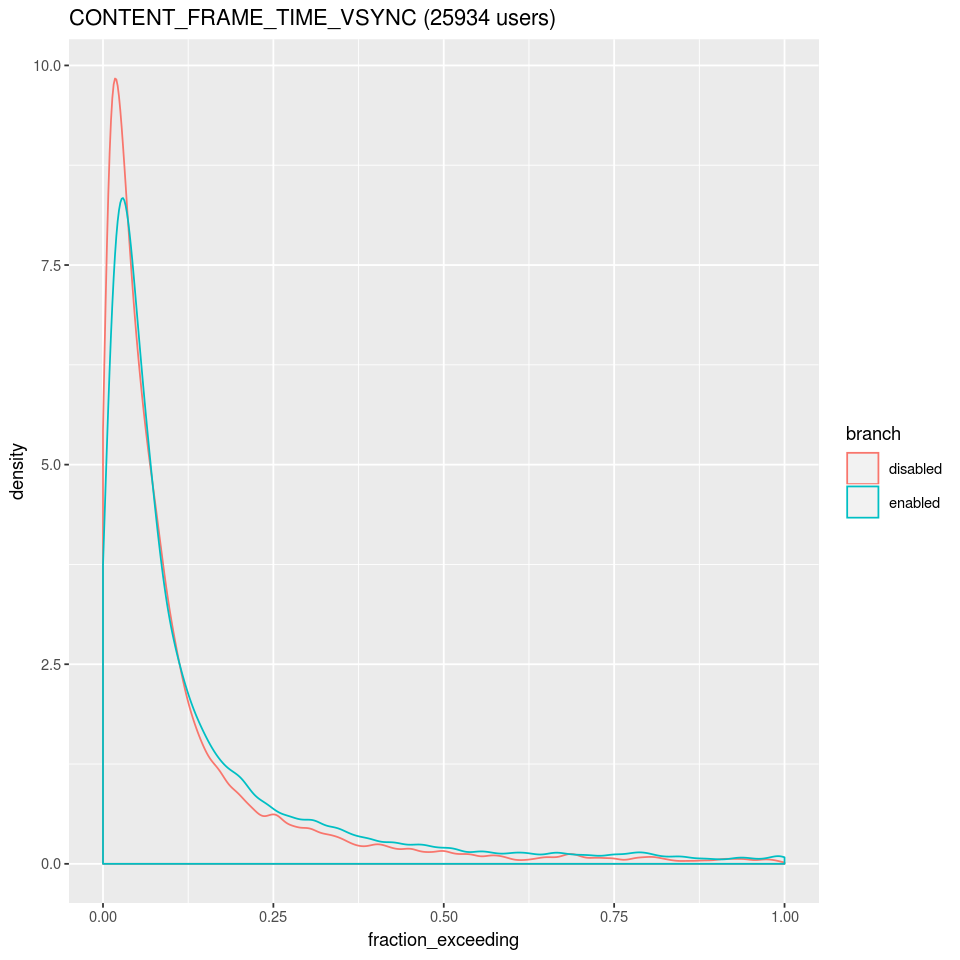

In [38]:
%r
slow_content_frame_time_vsync %>% ggplot(aes(x=fraction_exceeding, color=branch)) + geom_density() + labs(title=sprintf("CONTENT_FRAME_TIME_VSYNC (%d users)", nrow(slow_content_frame_time_vsync)))

In [39]:
%r
slow_content_frame_time %>% filter(app_build_id == '20190104093221') %>% filter(branch == 'enabled') %>% summary

client_id branch app_build_id normalized_channel
 Length:44 Length:44 Length:44 Length:44 
 Class :character Class :character Class :character Class :character 
 Mode :character Mode :character Mode :character Mode :character 
 
 
 
 threshold fraction_exceeding 
 Min. :192 Min. :0.0004654 
 1st Qu.:192 1st Qu.:0.0119995 
 Median :192 Median :0.0281412 
 Mean :192 Mean :0.0558194 
 3rd Qu.:192 3rd Qu.:0.0791488 
 Max. :192 Max. :0.2993783

In [40]:
%r
slow_content_frame_time %>% filter(app_build_id == '20190104093221') %>% filter(branch == 'disabled') %>% summary

client_id branch app_build_id normalized_channel
 Length:33 Length:33 Length:33 Length:33 
 Class :character Class :character Class :character Class :character 
 Mode :character Mode :character Mode :character Mode :character 
 
 
 
 threshold fraction_exceeding
 Min. :192 Min. :0.001746 
 1st Qu.:192 1st Qu.:0.005481 
 Median :192 Median :0.015723 
 Mean :192 Mean :0.031524 
 3rd Qu.:192 3rd Qu.:0.024150 
 Max. :192 Max. :0.241045

In [41]:
%r
  summarize_slow = function(df) {
    mystat = function(data, indices) {
      sample = data[indices,]
      median(sample[sample$branch == "enabled",]$fraction_exceeding, na.rm=TRUE) / median(sample[sample$branch == "disabled",]$fraction_exceeding, na.rm=TRUE)
    }

    ci = df %>%
      boot(mystat, 200, strata=factor(df$branch)) %>%
      boot.ci(0.95, type="basic")
    data.frame(
      ymin=ci$basic[4],
      y=ci$t0,
      ymax=ci$basic[5]
    ) * 100
  }
bind_rows(summarize_slow(slow_content_frame_time) %>% mutate(metric="slow_content_frame_time"),
          summarize_slow(slow_content_frame_time_vsync) %>% mutate(metric="slow_content_frame_time_vsync")) %>%
  select(metric, ymin, y, ymax)


metric ymin y ymax
1 slow_content_frame_time 149.5570 159.6090 165.7231
2 slow_content_frame_time_vsync 112.9476 118.4178 122.3407

In [42]:
%r
slow_content_frame_boot_p90 = function(df) {
  ci = boot(df$fraction_exceeding, function(data, x) quantile(data[x], 0.9, na.rm=TRUE), 1000) %>%
     boot.ci(0.95, "basic")
  data.frame(
    ymin=ci$basic[4],
    y=ci$t0,
    ymax=ci$basic[5]
  ) * 100
}

slow_content_frame_time_summary_p90 = slow_content_frame_time %>%
  group_by(normalized_channel, app_build_id, branch) %>%
  do(slow_content_frame_boot_p90(.))